# Getting 3hrly data for surface temp, and radiation variables
Need to get radiation variables and compare to the observations at summit station



### Questions: 
- Which experiment has the lowest surface temp bias?
- Why?
- In each model, which terms contribute the most to forcing?

In [6]:
# Import statements
import xarray as xr
xr.set_options(display_style='html')
import intake
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from scipy.io import netcdf_file
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import zarr
import re
import cartopy

data_path =  Path.home() / "repos/a500/" /'final/data/'

## Get CMIP models

Pull the data from the sit itself and put into pandas df in order to be able to visualize it.

In [18]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [19]:
dataframe = col.df
threeHourlyModels = dataframe[col.df['table_id'].str.contains("3hr")]

In [20]:
threeHourlyModels

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
27,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,3hr,prc,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
38,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,3hr,pr,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
41,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,E3hr,psl,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
62,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,E3hr,psl,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
95,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,3hr,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
...,...,...,...,...,...,...,...,...,...,...,...
503148,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,3hr,huss,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-ESM2/historica...,NaN,20210114
504939,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,vas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126
504940,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,uas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126
504941,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126


Look at the unique keys for all the entries in order to find the models we want

In [21]:
models = threeHourlyModels['source_id'].unique()
models

array(['HadGEM3-GC31-MM', 'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM',
       'GFDL-ESM4', 'GFDL-CM4', 'GFDL-CM4C192', 'IPSL-CM6A-LR',
       'CNRM-CM6-1', 'GISS-E2-1-G', 'BCC-CSM2-MR', 'CNRM-ESM2-1',
       'AWI-CM-1-1-MR', 'IPSL-CM6A-ATM-HR', 'CNRM-CM6-1-HR',
       'SAM0-UNICON', 'CanESM5', 'MPI-ESM-1-2-HAM', 'NESM3',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'MIROC6',
       'KACE-1-0-G', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MIROC-ES2L',
       'EC-Earth3-Veg', 'EC-Earth3', 'AWI-ESM-1-1-LR', 'EC-Earth3-Veg-LR',
       'UKESM1-0-LL', 'CMCC-CM2-SR5', 'HadGEM3-GC31-LL',
       'EC-Earth3-AerChem', 'IPSL-CM5A2-INCA', 'KIOST-ESM', 'TaiESM1',
       'IITM-ESM', 'CMCC-ESM2'], dtype=object)

## Model / Variable Info

### Monthly ice sheet SEB variables

| Variable id | Variable name|
|-------------|--------------|
|rsdsls|Ice Sheet Surface Downwelling Shortwave Radiation [W m-2]
|rsusIs|Ice Sheet Surface Upwelling Shortwave Radiation [W m-2]
|rldsIs|Ice Sheet Surface Downwelling Longwave Radiation [W m-2]
|rlusIs|Ice Sheet Surface Upwelling Longwave Radiation [W m-2]
|albsn|Snow Albedo [1]
|acabfIs|Ice Sheet Surface Mass Balance Flux [kg m-2 s-1]
|hfssIs|Ice Sheet Surface Upward Sensible Heat Flux [W m-2]
|hflsIs|Ice Sheet Surface Upward Latent Heat Flux [W m-2]

### 3hrly SEB variables

| Variable id | Variable name|
|-------------|--------------|
|rld|Downwelling Longwave Radiation [W m-2]
|rlds|Surface Downwelling Longwave Radiation [W m-2]
|rlus|Surface Upwelling Longwave Radiation [W m-2]
|rlu|Upwelling Longwave Radiation [W m-2]
|rsd|Downwelling Shortwave Radiation [W m-2]
|rsu|Upwelling Shortwave Radiation [W m-2]
|rsds|Surface Downwelling Shortwave Radiation [W m-2]
|rsus|Surface Upwelling Shortwave Radiation [W m-2]
|hfls|Surface Upward Latent Heat Flux [W m-2]
|hfss|Surface Upward Sensible Heat Flux [W m-2]

## Collect and subset data for each model

- Summit Station 72.6°N, 38.5°W; 3,211 m
- Data QA-ed for 2013-2014, so we will use that time period

In [ ]:
# track exceptions in case we care about them later
exceptions = list()

# a dictionary of dictionaries (each key is a model, and each value the pangeo dataset dictionary)
models_with_seb_variables = dict()
variables=['rld','rlds','rlus','rlu','rsd','rsu','rsds','rsus','hfls','hfss', 'ts', 'tslsi', 'tas', 'tsIs']
for model in enumerate(models):
    model_dict = dict()
    model_subset = col.search(table_id="3hr", variable_id = variables,# 'rsus', 
                                source_id = model, 
                                experiment_id = 'historical')
    try:
        model_dict = model_subset.to_dataset_dict(zarr_kwargs={'consolidated':True})
        if len(model_dict) > 0:
            #The keys in the returned dictionary of datasets are constructed as follows:
        	#'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
            models_with_seb_variables[model[1]] = model_dict
            print(f"Model '{model}' contains 3hr variables")
    except Exception as e:
        # pass
        exceptions.append(e)
    

In [92]:
models_with_seb_variables

{'HadGEM3-GC31-MM': {'CMIP.MOHC.HadGEM3-GC31-MM.historical.3hr.gn': <xarray.Dataset>
  Dimensions:         (lat: 324, bnds: 2, lon: 432, member_id: 1,
                       dcpp_init_year: 1, time: 475200)
  Coordinates:
      height          float64 ...
    * lat             (lat) float64 -89.72 -89.17 -88.61 ... 88.61 89.17 89.72
      lat_bnds        (lat, bnds) float64 dask.array<chunksize=(324, 2), meta=np.ndarray>
    * lon             (lon) float64 0.4167 1.25 2.083 2.917 ... 357.9 358.7 359.6
      lon_bnds        (lon, bnds) float64 dask.array<chunksize=(432, 2), meta=np.ndarray>
    * time            (time) object 1850-01-01 03:00:00 ... 2015-01-01 00:00:00
    * member_id       (member_id) object 'r1i1p1f3'
    * dcpp_init_year  (dcpp_init_year) float64 nan
  Dimensions without coordinates: bnds
  Data variables:
      tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 324, 432), meta=np.ndarray>
  Attributes: (12/63)
      

### Chosen model 
Only `CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr` has sensible/latent heat flux variables!

In [8]:
# Save off the model information we collected
models_with_seb_variables_file = f'{data_path}/models_with_seb_variables.pickle'

In [31]:
with open(f'{data_path}/models_with_seb_variables.pickle', 'wb') as handle:
    pickle.dump(models_with_seb_variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
# start here to reuse preprocessed data
with open(models_with_seb_variables_file, 'rb') as f:
    models_with_seb_variables = pickle.load(f)

In [6]:
# get each model subset to see if it has what we need (greenland) 
experiment_keys = list()
for model in enumerate(models_with_seb_variables):
    experiment_keys.extend([*models_with_seb_variables[model[1]]])

experiment_keys

['CMIP.MOHC.HadGEM3-GC31-MM.historical.3hr.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.3hr.gr1',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr2',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.3hr.gr',
 'CMIP.BCC.BCC-CSM2-MR.historical.3hr.gn',
 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.3hr.gr',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.3hr.gn',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.3hr.gr',
 'CMIP.SNU.SAM0-UNICON.historical.3hr.gn',
 'CMIP.CCCma.CanESM5.historical.3hr.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.3hr.gn',
 'CMIP.NUIST.NESM3.historical.3hr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.3hr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.3hr.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.3hr.gn',
 'CMIP.MIROC.MIROC6.historical.3hr.gn',
 'CMIP.NIMS-KMA.KACE-1-0-G.historical.3hr.gr',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.3hr.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.3hr.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.3hr.gr',
 '

In [94]:
# summit station 72.6°N, 38.5°W; 3,211 m
# 72.5, 321.5 --> (72,73), (-321, -322)
# data QA-ed for 2013-2014
lon_slice = slice(321, 323)
lat_slice = slice(72, 73)
time_slice = slice('2013', '2014')

for model in enumerate(models_with_seb_variables):
    keys = list(models_with_seb_variables[model[1]].keys())
    for experiment in enumerate(keys):
        dataset = (models_with_seb_variables[model[1]])[experiment[1]]
        if 'hfss' in dataset:
            subsetted_data = dataset.sel(lon = lon_slice, lat = lat_slice, time = time_slice)
            # print(subsetted_data['rlus'].values)
            # ds = subsetted_data.to_netcdf(f"{data_path}/{experiment[1]}.nc", mode='w')
            with open(f"{data_path}/{experiment[1]}.pickle", 'wb') as handle:
                pickle.dump(subsetted_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
subsetted_data

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 1, lon: 1, time: 11680, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * lat             (lat) float64 73.0
  * lon             (lon) float64 321.2
  * time            (time) object 2013-01-01 00:00:00 ... 2014-12-31 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_bnds       (time, bnds) object dask.array<chunksize=(11680, 1), meta=np.ndarray>
    height          float64 ...
Data variables:
    hfls            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 981, 1, 1), meta=np.ndarray>
    hfss            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 289, 1, 1), meta=np.ndarray>
    rlds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1071, 1, 1), meta=np.ndarray>
    rlus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1909, 1, 1), meta=np.ndarray>
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 2489, 1, 1), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1285, 1, 1), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 2482, 1, 1), meta=np.ndarray>
    tslsi           (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 582, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr2
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr2

### Clean and subset gfdl dataset

In [96]:
# subsetted_data.load().to_zarr(f"{data_path}/{experiment[1]}.zarr")

with open(f"{data_path}/CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1.pickle", 'rb') as f:
    gfdl = pickle.load(f)

In [97]:
gfdl

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 1, lon: 1, time: 11680, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * time            (time) object 2013-01-01 00:00:00 ... 2014-12-31 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_bnds       (time, bnds) object dask.array<chunksize=(11680, 1), meta=np.ndarray>
    height          float64 ...
Data variables:
    hfls            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 231, 1, 1), meta=np.ndarray>
    hfss            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    rlds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 333, 1, 1), meta=np.ndarray>
    rlus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 241, 1, 1), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 889, 1, 1), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 72, 1, 1), meta=np.ndarray>
    tslsi           (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 220, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

In [99]:


gfdl['datetime'] = gfdl.indexes['time'].to_datetimeindex()
gfdl['datetime']
# gfdl.to_netcdf(f"{data_path}/subsetted_gfdl_3hr.nc", mode='w')

C:\Users\melis\AppData\Local\Temp\ipykernel_13820\2942913534.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  gfdl['datetime'] = gfdl.indexes['time'].to_datetimeindex()


<xarray.DataArray 'tslsi' (member_id: 1, dcpp_init_year: 1, time: 11680,
                           lat: 1, lon: 1)>
dask.array<getitem, shape=(1, 1, 11680, 1, 1), dtype=float32, chunksize=(1, 1, 1254, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * time            (time) object 2013-01-01 00:00:00 ... 2014-12-31 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 ...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean (comment: over land and sea ice) time: point
    interp_method:  conserve_order2
    long_name:      Surface Temperature Where Land or Sea Ice
    original_name:  tslsi
    standard_name:  surface_temperature
    units:          K

In [100]:
# variables=['rld','rlds','rlus','rlu','rsd','rsu','rsds','rsus','hfls','hfss', 'ts', 'tslsi', 'tas', 'tsIs']

# 30 min observations
hfls = gfdl[['datetime','hfls']]
hfss =  gfdl[['datetime','hfss']]
rlds = gfdl[['datetime','rlds']]
rlus = gfdl[['datetime','rlus']]
rsds = gfdl[['datetime','rsds']]
rsus = gfdl[['datetime','rsus']]
tas  = gfdl[['datetime','tas']]
tslsi = gfdl[['datetime','tslsi']]

thirtyMinOffset = pd.Timedelta(unit='minutes', value=0)

hfls_3hr_avg = hfls.resample(datetime='3H', offset = thirtyMinOffset).mean()
hfss_3hr_avg = hfss.resample(datetime='3H', offset = thirtyMinOffset).mean()
rlds_3hr_avg = rlds.resample(datetime='3H', offset = thirtyMinOffset).mean()
rlus_3hr_avg = rlus.resample(datetime='3H', offset = thirtyMinOffset).mean()
rsds_3hr_avg = rsds.resample(datetime='3H', offset = thirtyMinOffset).mean()
rsus_3hr_avg = rsus.resample(datetime='3H', offset = thirtyMinOffset).mean()
tas_3hr_avg = tas.resample(datetime='3H', offset = thirtyMinOffset).mean()
tslsi_3hr_avg = tslsi.resample(datetime='3H', offset = thirtyMinOffset).mean()

gfdl_3hr = xr.merge([hfls_3hr_avg,hfss_3hr_avg, rlds_3hr_avg, rlus_3hr_avg, rsds_3hr_avg, rsus_3hr_avg, tas_3hr_avg, tslsi_3hr_avg])

In [101]:
hfls_3hr_avg

<xarray.Dataset>
Dimensions:         (datetime: 5840, member_id: 1, dcpp_init_year: 1,
                     time: 11680, lat: 1, lon: 1)
Coordinates:
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * time            (time) object 2013-01-01 00:00:00 ... 2014-12-31 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 ...
  * datetime        (datetime) datetime64[ns] 2013-01-01 ... 2014-12-31T21:00:00
Data variables:
    hfls            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 231, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

In [45]:
gfdl_3hr = gfdl_3hr.assign_coords(time=gfdl['datetime'] )
ds_dropped = gfdl_3hr.drop_dims('time')


gfdl_3hr


<xarray.Dataset>
Dimensions:         (datetime: 5840, member_id: 1, dcpp_init_year: 1,
                     time: 11680, lat: 1, lon: 1)
Coordinates:
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 ...
  * datetime        (datetime) datetime64[ns] 2013-01-01 ... 2014-12-31T21:00:00
    time            (datetime) datetime64[ns] 2013-01-01 ... 2014-12-31T21:00:00
Data variables:
    hfls            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 231, 1, 1), meta=np.ndarray>
    hfss            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1, 1), meta=np.ndarray>
    rlds            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 333, 1, 1), meta=np.ndarray>
    rlus            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1, 1), meta=np.ndarray>
    rsds            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 241, 1, 1), meta=np.ndarray>
    rsus            (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 889, 1, 1), meta=np.ndarray>
    tas             (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 72, 1, 1), meta=np.ndarray>
    tslsi           (datetime, member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 220, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

In [47]:
# save off processed data
gfdl_3hr_path = f"{data_path}/subsetted_gfdl_3hr.pickle"
# with open(gfdl_3hr_path, 'wb') as handle:
#     pickle.dump(gfdl_3hr, handle, protocol=pickle.HIGHEST_PROTOCOL)
gfdl_3hr.to_netcdf(f"{data_path}/subsetted_gfdl_3hr.nc", mode='w')

## Get observations

In [14]:
# netcdf get 2013-2014 observations
# summit_30min_jan2011tojun2014_seb_20160926.cdf
# with netCDF4.Dataset("summit_30min_jan2011tojun2014_seb_20160926.cdf", "r", auto_complex=True) as nc:
the_file = Path.home() / "repos/a500/" /'final/data/summit_30min_jan2011tojun2014_seb_20160926.cdf'
# obs_all = netcdf_file(the_file, 'r')
ds1 = xr.open_dataset(the_file)
# ds1['time'].data
# ds1.loc[2013:2014, 'yyyy']
year_array = ds1['yyyy'].values
time_slice = np.where(year_array >= 2013)[0]
start = time_slice[0]
stop = time_slice[-1]

time_subset = ds1.sel(time=slice(start,stop))
# time_subset.variables
ds1.info()

xarray.Dataset {
dimensions:
	time = 61296 ;

variables:
	float32 lat() ;
		lat:long_name = Latitude ;
		lat:units = deg N ;
	float32 lon() ;
		lon:long_name = Longitude ;
		lon:units = deg E ;
	timedelta64[ns] base_time() ;
		base_time:long_name = Time since 1970-01-01 00:00:00 ;
	timedelta64[ns] time_offset(time) ;
		time_offset:long_name = Time since base_time ;
	float32 hour(time) ;
		hour:long_name = Hour ;
		hour:units = Start time of the averaged 30min data of the day [Hour,UTC] ;
	float32 yyyy(time) ;
		yyyy:long_name = Year ;
		yyyy:units = Year ;
	float32 mm(time) ;
		mm:long_name = Month of the year ;
		mm:units = Year ;
	float32 dd(time) ;
		dd:long_name = Day of the month ;
		dd:units = Day ;
	float32 hh(time) ;
		hh:long_name = Hour of the day ;
		hh:units = Hour [UTC] ;
	timedelta64[ns] nn(time) ;
		nn:long_name = Minute of the hour ;
	timedelta64[ns] ss(time) ;
		ss:long_name = Seconds of the minute ;
	float32 swup(time) ;
		swup:long_name = Shortwave upwelling radiatio

In [15]:
time_subset['dd'].values

zeros = np.where(time_subset['dd'].values == 0)[0]
# the minutes are in nanoseconds, which is fun
print(len(time_subset['nn'].values / (1000000000 * 60)))

26207


In [16]:
# Let's clean up the integer time format, because it's annoying

# Create a datetime object for each time point
datetimes = pd.to_datetime({
    'year':  map(int, time_subset['yyyy'].values),
    'month': map(int, time_subset['mm'].values),
    'day': map(int, time_subset['dd'].values),
    'hour': map(int, time_subset['hh'].values),
    'minute': map(int, time_subset['nn'].values / (1000000000 * 60))
})


# Replace the integer time dimension with the new datetime dimension
time_dimension_ds = time_subset.copy()
time_dimension_ds['datetime'] = datetimes

In [17]:
time_dimension_ds['datetime']

<xarray.DataArray 'datetime' (dim_0: 26207)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',
       '2013-01-01T01:00:00.000000000', ...,
       '2014-06-30T22:00:00.000000000', '2014-06-30T22:30:00.000000000',
       '2014-06-30T23:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 ... 26201 26202 26203 26204 26205 26206

In [64]:
# lwdn - lwup + swdn - swup - sh_bulk(or sh_cv if avail.) - lh_grad + cond_flux + storage_flux
seb_obs_vars = ['lwdn','lwup'  'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']

# 30 min observations
lwdn = time_dimension_ds[['datetime','lwdn']]
lwup =  time_dimension_ds[['datetime','lwup']]
swdn = time_dimension_ds[['datetime','swdn']]
swup = time_dimension_ds[['datetime','swup']]
sh_bulk = time_dimension_ds[['datetime','sh_bulk']]
lh_grad = time_dimension_ds[['datetime','lh_grad']]
cond_flux = time_dimension_ds[['datetime','cond_flux']]
storage_flux = time_dimension_ds[['datetime','storage_flux']]
surface_temp = time_dimension_ds[['datetime','Tsurf']]
lwp = time_dimension_ds[['datetime','lwp']]

thirtyMinOffset = pd.Timedelta(unit='minutes', value=0)

lwdn_3hr_avg = lwdn.resample(datetime='3H', offset = thirtyMinOffset).mean()
lwup_3hr_avg = lwup.resample(datetime='3H', offset = thirtyMinOffset).mean()
swdn_3hr_avg = swdn.resample(datetime='3H', offset = thirtyMinOffset).mean()
swup_3hr_avg = swup.resample(datetime='3H', offset = thirtyMinOffset).mean()
sh_bulk_3hr_avg = sh_bulk.resample(datetime='3H', offset = thirtyMinOffset).mean()
lh_grad_3hr_avg = lh_grad.resample(datetime='3H', offset = thirtyMinOffset).mean()
cond_flux_3hr_avg = cond_flux.resample(datetime='3H', offset = thirtyMinOffset).mean()
storage_flux_3hr_avg = storage_flux.resample(datetime='3H', offset = thirtyMinOffset).mean()
surface_temp_3hr_avg = surface_temp.resample(datetime='3H', offset = thirtyMinOffset).mean()
lwp_3hr_avg = lwp.resample(datetime='3H', offset = thirtyMinOffset).mean()

In [91]:
lwdn_3hr_avg['lwdn']
print(lwdn.shape())

AttributeError: 'Dataset' object has no attribute 'shape'

In [65]:
obs_3hr = xr.merge([lwdn_3hr_avg, lwup_3hr_avg, swdn_3hr_avg, swup_3hr_avg, sh_bulk_3hr_avg, lh_grad_3hr_avg, cond_flux_3hr_avg, storage_flux_3hr_avg, surface_temp_3hr_avg, lwp_3hr_avg])

In [52]:
obs_3hr

<xarray.Dataset>
Dimensions:       (datetime: 4368, time: 26207)
Coordinates:
  * datetime      (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00
Dimensions without coordinates: time
Data variables:
    lwdn          (datetime, time) float32 85.21 85.46 83.23 ... 170.9 174.8
    lwup          (datetime, time) float32 92.22 93.66 93.7 ... 244.4 240.6
    swdn          (datetime, time) float32 -0.2841 -1.896 -1.922 ... 228.9 189.5
    swup          (datetime, time) float32 0.4297 1.105 1.109 ... 201.4 167.1
    sh_bulk       (datetime, time) float32 -999.0 -999.0 ... -13.74 -10.81
    lh_grad       (datetime, time) float32 -999.0 -999.0 ... -29.35 -33.42
    cond_flux     (datetime, time) float32 -999.0 -999.0 ... -999.0 -999.0
    storage_flux  (datetime, time) float32 -999.0 -999.0 ... -999.0 -999.0
    Tsurf         (datetime, time) float32 -72.27 -71.48 ... -16.63 -17.65
    lwp           (datetime, time) float32 0.7633 0.9361 ... -999.0 -999.0
Attributes:
    missing_data_flag:      -999
    Data_source:        Location: Summit Camp, Greenland. Measurements made b...
    Averaging_time:     30minute averaged values for January 2011 to June 2014
    Contact:            Questions? Contact Nate Miller (millernb@colorado.edu...
    File_created:       date this NetCDF file was created on: Mon Sep 26 15:4...
    Reference:          Miller et. al. 2016 The Cryosphere (discussion paper)...
    Example_SEB:        Example SEB calculation = lwdn - lwup + swdn - swup -...

In [63]:
# save off processed data
obs_3hr_path = f"{data_path}/subsetted_obs_3hr.pickle"
with open(obs_3hr_path, 'wb') as handle:
    pickle.dump(obs_3hr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# obs = obs_3hr.to_netcdf(f"{data_path}/subsetted_obs_3hr.nc", mode='w')


KeyboardInterrupt: 

## Forcing vs Response in each model

Example SEB calculation = lwdn - lwup + swdn - swup - sh_bulk(or sh_cv if avail.) - lh_grad + cond_flux + storage_flux

Response variables:
- lh + sh + g - lwup

In [16]:
# Save off the SEB and the response terms
# ['rld','rlds','rlus','rlu','rsd','rsu','rsds','rsus','hfls','hfss']
g = gfdl['rlds'] - gfdl['rlus'] + gfdl['rsds'] -  gfdl['rsus'] - gfdl['hfls'] - gfdl['hfss']
gfdl['g'] = g

model_response_terms = - gfdl['rlus'] +  gfdl['g'] + gfdl['hfls'] + gfdl['hfss']
gfdl['model_response_terms'] = model_response_terms

In [21]:
gfdl

<xarray.Dataset>
Dimensions:               (bnds: 2, lat: 1, lon: 1, time: 11680, member_id: 1,
                           dcpp_init_year: 1, time2: 11680)
Coordinates:
  * bnds                  (bnds) float64 1.0 2.0
  * lat                   (lat) float64 72.5
  * lon                   (lon) float64 321.9
  * time                  (time) object 2013-01-01 00:00:00 ... 2014-12-31 22...
  * member_id             (member_id) object 'r1i1p1f1'
  * dcpp_init_year        (dcpp_init_year) float64 nan
    lat_bnds              (lat, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds              (lon, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_bnds             (time, bnds) object dask.array<chunksize=(11680, 1), meta=np.ndarray>
    height                float64 ...
  * time2                 (time2) datetime64[ns] 2013-01-01 ... 2014-12-31T22...
Data variables:
    hfls                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 231, 1, 1), meta=np.ndarray>
    hfss                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    rlds                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 333, 1, 1), meta=np.ndarray>
    rlus                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    rsds                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 241, 1, 1), meta=np.ndarray>
    rsus                  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 889, 1, 1), meta=np.ndarray>
    tas                   (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 72, 1, 1), meta=np.ndarray>
    tslsi                 (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 220, 1, 1), meta=np.ndarray>
    g                     (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    model_response_terms  (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

In [100]:
seb = lwdn_3hr_avg['lwdn'] - lwup_3hr_avg['lwup'] + swdn_3hr_avg['swdn'] - swup_3hr_avg['swup'] - sh_bulk_3hr_avg['sh_bulk'] - lh_grad_3hr_avg['lh_grad'] + cond_flux_3hr_avg['cond_flux'] + storage_flux_3hr_avg['storage_flux']
response_terms = sh_bulk_3hr_avg['sh_bulk'] + lh_grad_3hr_avg['lh_grad'] + cond_flux_3hr_avg['cond_flux'] + storage_flux_3hr_avg['storage_flux'] - lwup_3hr_avg['lwup

In [102]:
seb
# response_terms

<xarray.DataArray (datetime: 4368, time: 26207)>
array([[   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ],
       [   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ],
       [   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ],
       ...,
       [   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ],
       [   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ],
       [   -7.7211914,   -11.203857 ,   -13.499756 , ..., -2009.991    ,
        -2000.9131   , -1997.1777   ]], dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00
Dimensions without coordinates: time

## Temperature plots

In [66]:
obs_3hr_path = f"{data_path}/subsetted_obs_3hr.pickle"

# with open(obs_3hr_path, 'rb') as handle:
#     obs_3hr = pickle.load(obs_3hr_path)

T_obs = obs_3hr['Tsurf']
# T_model = gfdl['tslsi'].values

# T_model

In [87]:
obs_3hr

<xarray.Dataset>
Dimensions:       (datetime: 4368, time: 26207)
Coordinates:
  * datetime      (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00
Dimensions without coordinates: time
Data variables:
    lwdn          (datetime, time) float32 85.21 85.46 83.23 ... 170.9 174.8
    lwup          (datetime, time) float32 92.22 93.66 93.7 ... 244.4 240.6
    swdn          (datetime, time) float32 -0.2841 -1.896 -1.922 ... 228.9 189.5
    swup          (datetime, time) float32 0.4297 1.105 1.109 ... 201.4 167.1
    sh_bulk       (datetime, time) float32 -999.0 -999.0 ... -13.74 -10.81
    lh_grad       (datetime, time) float32 -999.0 -999.0 ... -29.35 -33.42
    cond_flux     (datetime, time) float32 -999.0 -999.0 ... -999.0 -999.0
    storage_flux  (datetime, time) float32 -999.0 -999.0 ... -999.0 -999.0
    Tsurf         (datetime, time) float32 -72.27 -71.48 ... -16.63 -17.65
    lwp           (datetime, time) float32 0.7633 0.9361 ... -999.0 -999.0
Attributes:
    missing_data_flag:      -999
    Data_source:        Location: Summit Camp, Greenland. Measurements made b...
    Averaging_time:     30minute averaged values for January 2011 to June 2014
    Contact:            Questions? Contact Nate Miller (millernb@colorado.edu...
    File_created:       date this NetCDF file was created on: Mon Sep 26 15:4...
    Reference:          Miller et. al. 2016 The Cryosphere (discussion paper)...
    Example_SEB:        Example SEB calculation = lwdn - lwup + swdn - swup -...

In [85]:
# tslsi_day_avg = gfdl.resample(datetime='1m').mean()
tsurf_day_avg = obs_3hr[['datetime', 'Tsurf']].resample(datetime='1m').mean()

In [86]:
tsurf_day_avg['Tsurf']

<xarray.DataArray 'Tsurf' (datetime: 18, time: 26207)>
array([[-72.272156, -71.48029 , -71.44318 , ..., -15.448726, -16.630621,
        -17.65204 ],
       [-72.27222 , -71.48028 , -71.44316 , ..., -15.448725, -16.63062 ,
        -17.65205 ],
       [-72.272156, -71.48029 , -71.44318 , ..., -15.448726, -16.630621,
        -17.65204 ],
       ...,
       [-72.27218 , -71.48029 , -71.44317 , ..., -15.448726, -16.63062 ,
        -17.652046],
       [-72.272156, -71.48029 , -71.44318 , ..., -15.448726, -16.630621,
        -17.65204 ],
       [-72.27218 , -71.48029 , -71.44317 , ..., -15.448726, -16.63062 ,
        -17.652046]], dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-06-30
Dimensions without coordinates: time
Attributes:
    long_name:  Surface temperature derived from the LW measurements. emissiv...
    units:      degrees C

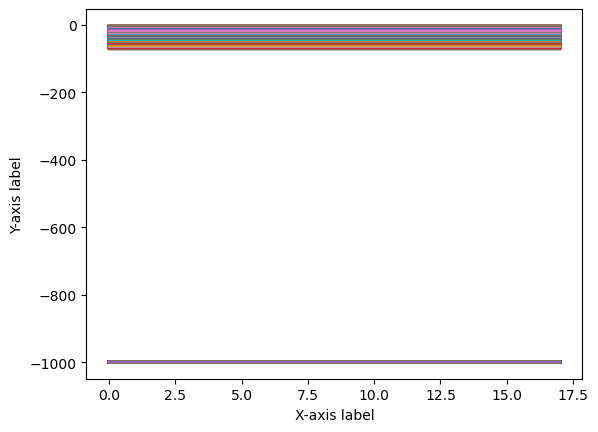

In [73]:
fig, ax = plt.subplots()
# ax.plot(T_model['datetime'].values, T_model, label='GFDL-CM4')
ax.plot(
    # tsurf_day_avg['datetime'].values, 
    tsurf_day_avg['Tsurf'].values, label='Obs')
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
plt.show()

# old

In [ ]:
bc_dset = xr.open_dataset('can_bc_dset.zarr')
mean_precip = bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
plt.figure()
mean_precip.mean('member_id').pr.plot()
plt.title("Averaged Yearly precipitation for the CanESM5 GCM")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
var_precip = bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
var_precip.std('member_id').pr.plot()
plt.title("Standard deviation of precipitation for the CanESM5 members")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
hist_data = bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
hist_data = hist_data.sel(year=2010)
hist_data.pr.plot.hist()
plt.title("2010 Precipitation Average distribution across the CanESM5 members")
plt.xlabel('Precipitation total (mm)')
plt.ylabel('Number')

In [ ]:
## Try plotting on a map for 2010

data2010 = bc_dset.sel(time='2010')
precip_data2010 = data2010.groupby('time.year').mean('time')*86400*365
precip_data2010 = precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -110, 44, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



precip_data2010.pr.plot(ax=ax,cmap='coolwarm')
ax.title.set_text("Precipitation total for 2010")

# Collect

In [ ]:
hadGEM = False
if hadGEM:
    had_subset = col.search(table_id="Amon", variable_id = "pr", source_id = "HadGEM3-GC31-MM", experiment_id = 'historical')
    dset_dict = had_subset.to_dataset_dict(zarr_kwargs={'consolidated':True})
    had_dset = dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn']
    had_bc_dset = had_dset.sel(lon = slice(225.4, 239.6), lat = slice(48.835241, 59.99702), time = slice('1960', '2010'))
    had_bc_dset.load().to_zarr('had_bc_dset.zarr')
    print('done')

In [ ]:
had_bc_dset = xr.open_dataset('had_bc_dset.zarr')
mean_precip_had = had_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
plt.figure()
mean_precip_had.mean('member_id').pr.plot()
plt.title("Averaged Yearly precipitation for the HadGEM3 GCM")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
had_std_precip = had_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
had_std_precip.std('member_id').pr.plot()
plt.title("Standard deviation of precipitation for the HadGEM members")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
had_hist_data = had_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
had_hist_data = had_hist_data.sel(year=2010)
had_hist_data.pr.plot.hist()
plt.title("2010 Precipitation Average distribution across the HadGEM members")
plt.xlabel('Precipitation total (mm)')
plt.ylabel('Number')

In [ ]:
had_data2010 = had_bc_dset.sel(time='2005')
had_precip_data2010 = had_data2010.groupby('time.year').mean('time')*86400*365
had_precip_data2010 = had_precip_data2010.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax2 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax2.set_extent([-140, -110, 40, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax2.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



had_precip_data2010.pr.plot(ax=ax2,cmap='coolwarm')
ax.title.set_text("Precipitation total for 2010")

# GISS

In [ ]:
GISS = False
if GISS:
    gis_subset = col.search(table_id="Amon", variable_id = "pr", source_id = "GISS-E2-1-H", experiment_id = 'historical')
    dset_dict = gis_subset.to_dataset_dict(zarr_kwargs={'consolidated':True})
    gis_dset = dset_dict['CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn']
    gis_bc_dset = gis_dset.sel(lon = slice(226.25, 238.75), lat = slice(48.835241, 59.99702), time = slice('1960', '2010'))
    gis_bc_dset.load().to_zarr('gis_bc_dset.zarr')

In [ ]:
gis_bc_dset = xr.open_dataset('gis_bc_dset.zarr')
mean_precip_gis = gis_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
plt.figure()
mean_precip_gis.mean('member_id').pr.plot()
plt.title("Averaged Yearly precipitation for the GISS GCM")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
gis_std_precip = gis_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
gis_std_precip.std('member_id').pr.plot()
plt.title("Standard deviation of precipitation for the HadGEM members")
plt.xlabel('Year')
plt.ylabel('Precipitation total (mm)')

In [ ]:
gis_hist_data = gis_bc_dset.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
gis_hist_data = gis_hist_data.sel(year=2010)
gis_hist_data.pr.plot.hist()
plt.title("2010 Precipitation Average distribution across the GISS members")
plt.xlabel('Precipitation total (mm)')
plt.ylabel('Number')

In [ ]:
gis_data1990 = gis_bc_dset.sel(time='2010')
gis_precip_data1990 = gis_data1990.groupby('time.year').mean('time')*86400*365
gis_precip_data1990 = gis_precip_data1990.mean('member_id')

fig = plt.figure(1, figsize=[30,13])

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.set_extent([-140, -110, 40, 60])

resol = '50m'

provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)



gis_precip_data1990.pr.plot(ax=ax,cmap='coolwarm')

### Creating plots with all 3 models

In [ ]:
time = mean_precip_gis.year
fig, axs = plt.subplots(1, 1, figsize=(15, 8))
axs.plot(time,mean_precip_gis.mean('member_id').pr,label='gis')
axs.plot(time, mean_precip_had.mean('member_id').pr,label='hadley')
axs.plot(time, mean_precip.mean('member_id').pr,label='cccma')
axs.legend();